In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend



## Constants

## Radar constants

In [331]:
B = 194e6 # Sweep Bandwidth 
T =  1/B # Sweep Time
N = 256 # Sample Length
CPI =N*T # Coherent Processing Interval (CPI)
M = 4 # ignored samples
L = 256 # Chirp Total
c = 299792458 # Speed ​​of Light
f0 = 24028e6 # Start Frequency
f_R = 24.125e9 # freq radar
clk = 38461538 #Core clock
S_clk = 12 # Core clocks per sample
delay = 11106 #Initial delay

wave_length = c/f_R

NumRangeFFT = 256 # Range FFT Length
NumDopplerFFT = 256 # Doppler FFT Length

# Range
rangeRes = 150e6*(N+M)/(N*B) # Range Resolution
maxRange = (N-1)*rangeRes # Max Range
#speed
velRes = wave_length*clk/(2*N*(S_clk*(N+M)+delay)) # Velocity Resolution
maxVel = velRes * (N/2-1) # Max Velocity
print("Coherent Processing Interval (CPI): ", CPI)
print("Pulse length: ", T)
print("Wave length: ", wave_length)
print("Range Resolution: ", rangeRes)
print("Velocity Resolution: ", velRes*3.6, "km/h")
print("Max Range: ", maxRange)
print("Max Velocity: ", maxVel*3.6, "km/h")


Coherent Processing Interval (CPI):  1.3195876288659794e-06
Pulse length:  5.154639175257732e-09
Wave length:  0.01242663038341969
Range Resolution:  0.7852770618556701
Velocity Resolution:  0.23622712431983353 km/h
Max Range:  200.24565077319588
Max Velocity:  30.000844788618856 km/h


In [332]:
print(c/2/f_R/T/NumDopplerFFT*3.6)

16950.70050738342


In [333]:
c = 3*10**8 # speed of ligth
f_0 = 24.125*10**9 # frequenzy of radar
w = c / f_0 # wavelength
v = 30/3.6 # max speed mesurabol by radar
f_max = v*2/w*2 # max frequenzy mesurabol by radar
clk = 38461538 # clock frekuenzy
s_clk =12 #clocks pr sample
sample_period = 1/250000 # sample period
sample_frek = 1/sample_period # sample frekuenzy

In [334]:
print(sample_frek)
print(f_max)

250000.0
2680.5555555555557


## Read in the data

In [335]:
try:
    with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
        data = f.read()
    
        
        
except IOError as e:
    print(e)

# RADC

TYPE:  RADC
length: 786432
786432


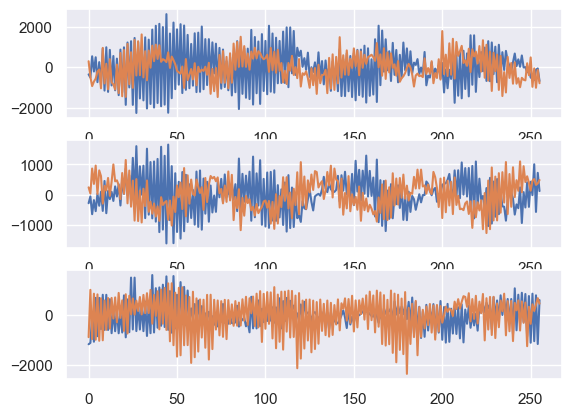

In [336]:
data_type = data[:4].decode()
print("TYPE: ", data_type)
length = int.from_bytes(
    data[4:8], byteorder="little", signed=False)
print("length:", length)
data_RADC = data[8:8+length]
print(len(data_RADC))
data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
data_RADC = data_RADC.reshape(3,256,2,256)
data_RADC = detrend(data_RADC, axis=3)

fig, axs = plt.subplots(3, 1)
axs[0].plot(data_RADC[0,10,0,:])
axs[0].plot(data_RADC[0,10,1,:])
axs[1].plot(data_RADC[1,10,0,:])
axs[1].plot(data_RADC[1,10,1,:])
axs[2].plot(data_RADC[2,10,0,:])
axs[2].plot(data_RADC[2,10,1,:])

plt.show()

## FFT

In [337]:
def fft_filter(data, sample_period):
    """
    This function takes a data matrix and filters it with a frequency range.
    :param data:
    :param sample_period:
    :param freq_range:
    :return:
    """

    # Generate frequency axis and take FFT
    spectrum = np.fft.fft(data, 256)  # takes FFT of all channels withe zero padding
    spectrum = np.trim_zeros(spectrum, trim='fb')
    print(len(spectrum))
    power_spectrum = 20*np.log10(np.abs(spectrum))
    num_of_samples = data.shape[0]  # returns shape of matrix
   
    freq = np.fft.fftfreq(n=len(data), d=sample_period)
    freq = np.fft.fftshift(freq,)
    power_spectrum = np.fft.fftshift(power_spectrum)
    
    return power_spectrum, freq

256
256


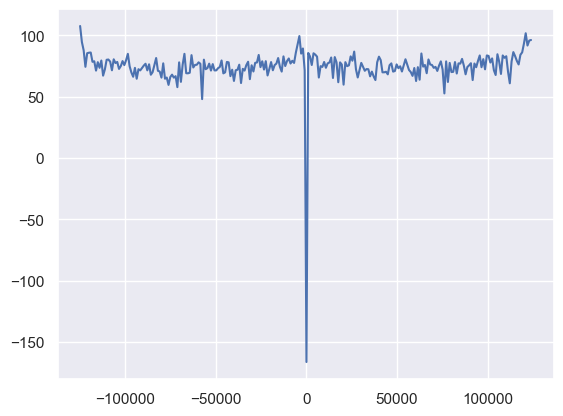

In [338]:
data_iq = (data_RADC[0,10,0,:]+1j*data_RADC[0,10,1,:])
print(len(data_iq))
power_spectrum, freq = fft_filter(data_iq, sample_period)
#print(freq[np.argmax(power_spectrum)])
plt.figure()
plt.plot(freq,power_spectrum)
#plt.xlim(-1000,1000)
#plt.ylim(0,50)
plt.show()

## Filter

In [339]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis=3)
    return y

In [340]:

  # desired cutoff frequency of the filter, Hz
b, a = butter_lowpass(f_max, sample_frek)
y = butter_lowpass_filter(detrend(data_RADC), f_max, sample_frek,5)


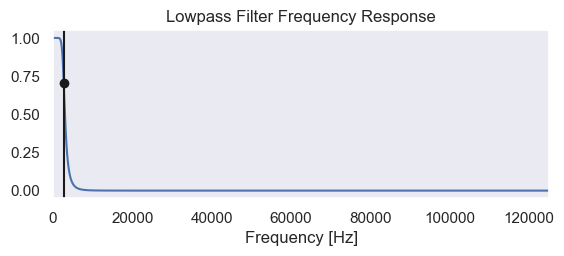

In [341]:
w, h = freqz(b, a, fs=sample_frek, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(f_max, 0.5*np.sqrt(2), 'ko')
plt.axvline(f_max, color='k')
plt.xlim(0, 0.5*sample_frek)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

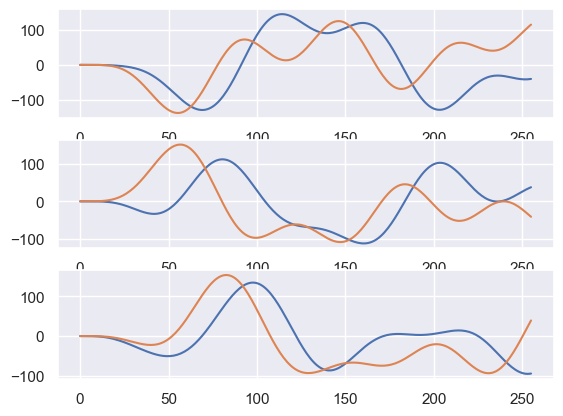

In [342]:
fig, axs = plt.subplots(3, 1)
axs[0].plot(y[0,0,0,:])

axs[0].plot(y[0,0,1,:])
axs[1].plot(y[1,0,0,:])
axs[1].plot(y[1,0,1,:])
axs[2].plot(y[2,0,0,:])
axs[2].plot(y[2,0,1,:])

plt.show()

256
-1953.125


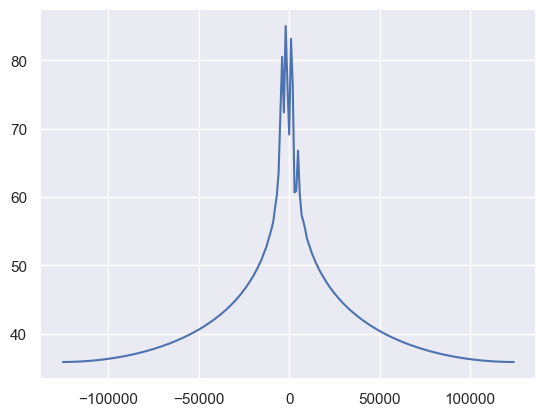

In [343]:
data_iq = (y[0,0,0,:]+1j*y[0,0,1,:])
power_spectrum_2, freq_2 = fft_filter(data_iq, sample_period)
print(freq_2[np.argmax(power_spectrum_2)])
plt.figure()
plt.plot(freq_2,power_spectrum_2)
#plt.xlim(-100000,100000)
#plt.ylim(0,50)
plt.show()

# RMRD


TYPE:  RMRD
length: 262144
76847
2176


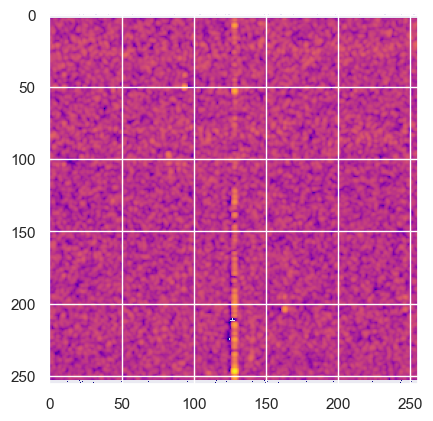

In [344]:
data_type = data[8+length:8+length+4].decode()
print("TYPE: ", data_type)
length_2 = int.from_bytes(
    data[8+length+4:8+length+4+4], byteorder="little", signed=False)
print("length:", length_2)
data_RMRD = data[8+length+8:8+length+8+length_2]
data_RMRD = np.frombuffer(data_RMRD,dtype=np.uint32)
    
    

    
data_RMRD = data_RMRD.reshape(256,256)
print(np.max(data_RMRD))
print(np.argmax(data_RMRD))
data_RMRD = np.flip(data_RMRD, axis=0)
plt.imshow(data_RMRD, cmap='plasma',norm=LogNorm())
plt.show()

(256, 256)


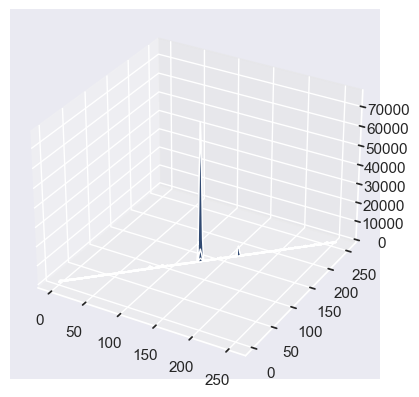

In [353]:
print(np.shape(data_RMRD))
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(np.arange(256),np.arange(256),data_RMRD)

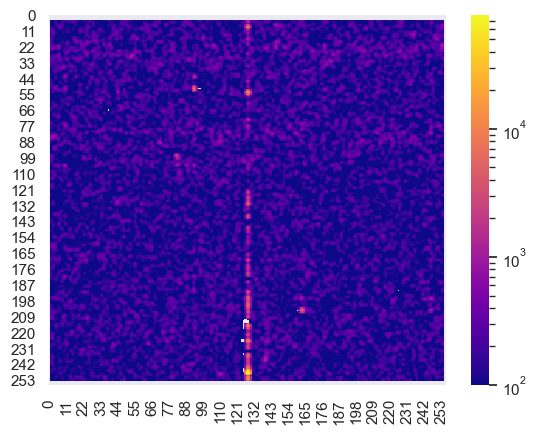

In [345]:


ax = sns.heatmap(data_RMRD,norm =LogNorm(vmin=100),cmap='plasma')

# Doppler processing

## Create the doppler matrix

In [356]:
data_IF = data_RADC[:,:,0,:] + 1j*data_RADC[:,:,1,:]
df =pd.DataFrame(data_IF[0,:,:])
df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-164.432393+631.897860j,-532.867727-488.199868j,394.696939-424.297597j,-437.738396-632.395325j,345.826270-680.493053j,-550.609064-520.590782j,920.955602-584.688510j,-1143.479732-1160.786238j,1064.084934+935.116033j,-744.3504010-888.9816950j,...,416.475401-1344.143305j,48.040066-0624.2410330j,111.604732+175.661238j,-80.830602-704.436490j,-529.265936+799.465782j,-481.701270-992.631947j,-562.1366040+463.2703250j,-66.571939-736.827403j,-403.007273+95.074868j,-739.442607-881.022860j
1,-272.444553+276.980058j,-448.842046-138.791354j,238.760460-650.562766j,-241.637034-794.334178j,717.965473-890.105591j,-610.432021-585.877003j,589.170485-681.648415j,-1299.227008-1145.419827j,1100.375498+934.808761j,-1172.021996-1224.962652j,...,253.771996-898.787348j,-50.625498-0946.5587610j,-99.022992-162.330173j,-163.420485-418.101585j,-451.8179709-1.8729970j,-772.215473-705.644409j,-1012.612966+1054.584178j,-389.010460-561.187234j,-437.407954-288.958646j,-517.805447-1392.730058j
2,-386.389591+290.534047j,-403.032124-221.471612j,492.325343-813.477272j,-20.317189-429.482931j,715.040278-797.488590j,-677.602255-589.494249j,921.755213-509.499908j,-1046.887320-1053.505568j,760.470148+850.488773j,-680.1723850-749.5168860j,...,-48.452615-1006.858114j,-209.095148-974.863773j,-17.7376800-94.8694320j,13.619787-622.875092j,-259.022745+65.119249j,-627.665278-734.886410j,-628.3078110-62.8920690j,-116.950343-750.897728j,-37.592876+353.096612j,-822.235409-734.909047j
3,-125.352140-130.588521j,-429.705751-322.397631j,561.940639-738.206741j,49.587028-546.015850j,849.233417-881.824960j,-415.120193-689.634070j,368.526196-33.443179j,-703.827415-1409.252289j,863.818975+686.938602j,-912.5346360-704.8705080j,...,75.6596360-35.6294920j,27.306025-0627.4386020j,-37.047585-467.247711j,-277.401196-627.056821j,-517.754807+125.134070j,-342.108417-818.675040j,-390.4620280+397.5158500j,-102.815639-738.293259j,-23.169249-306.102369j,-695.522860-497.911479j
4,-175.029183-177.165856j,-287.449542-97.186124j,320.1300908-1.2063920j,-32.290261-721.226659j,479.289380-497.246927j,-577.130980-257.267195j,78.448661-225.287463j,-721.971698-1121.307731j,509.607942+958.672002j,-1074.812417-1409.348266j,...,-134.437583-598.151734j,-502.857942-822.172002j,-183.278302-198.192269j,-183.698661-534.212537j,-728.119020+457.767195j,-408.539380-1286.253073j,-488.9597390+393.7266590j,86.619902-790.293608j,-57.800458+841.686124j,-458.220817-886.334144j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,104.770914+456.406615j,-439.478759-103.322065j,632.271567-71.050744j,-599.978107-646.779423j,391.772219-294.508103j,-376.477455-902.236782j,439.272871-725.965461j,-904.976802-1253.694141j,566.773524+394.577180j,-1033.476150-949.151499j,...,-532.648850-500.848501j,27.101476-0916.5771800j,-437.148198-708.305859j,-405.397871-580.034539j,-229.647545+28.236782j,-133.897219-931.491897j,-22.146893+0492.7794230j,-118.396567-642.949256j,-214.646241+381.322065j,-582.895914-402.406615j
252,-60.731518+352.102140j,-556.973329-287.678073j,482.784859-191.458286j,-397.456952-735.238499j,178.301236-511.018711j,-621.940576-382.798924j,97.817613-334.579137j,-1006.424199-1406.359350j,977.333989+465.860437j,-1534.907822-589.919776j,...,-88.217178-1033.830224j,-472.458989-1017.610437j,-216.700801-249.390650j,55.057387-361.170863j,-153.184424+199.048924j,-617.426236-648.731289j,-521.6680480+551.4884990j,-73.909859-120.291714j,-618.151671-344.071927j,-346.393482-583.852140j
253,-104.855545+449.510214j,-409.494913-414.475160j,613.865719-286.460534j,-490.773650-894.445909j,436.586982-926.431283j,-620.052386-558.416657j,563.308246-430.402031j,-877.331123-1422.387406j,1250.029509+561.627220j,-1006.609859-462.358154j,...,153.859859-1130.891846j,-358.779509-1210.877220j,-119.418877-250.862594j,-344.058246-506.847969j,-488.697614+53.166657j,-457.336982-890.818717j,-313.9763500+613.1959090j,-138.615719-346.789466j,-123.255087+181.22

In [354]:
data_range_fft = np.fft.fft(data_IF[0], axis=1)
data_doppler_fft = np.fft.fft(data_range_fft, axis=0)
data_real = np.real(data_doppler_fft)
df =pd.DataFrame(data_real)
df


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-6.262708e-07,-1.714728e+06,-2.352350e+06,530493.622859,3.656834e+06,-3.601009e+06,-2.103962e+06,-292794.154558,-830471.762826,-59085.857836,...,-2.553164e+06,-784780.528072,986551.257799,-302127.764190,133437.160022,514831.964019,-4.544263e+06,-1.263273e+06,-880092.165866,-1.435999e+06
1,-8.513717e-09,-3.379671e+04,-7.582349e+04,-12220.891646,-1.340047e+05,5.620781e+04,4.666061e+04,-51975.408106,47967.467717,-49828.259198,...,-7.892023e+03,112538.610649,15207.443425,68858.370814,45717.932747,173307.576572,-1.900797e+05,5.122267e+04,-132596.590554,-8.917431e+04
2,-3.492489e-08,-1.107511e+03,-3.827570e+04,-95164.458875,-1.337945e+04,1.802656e+04,-1.784981e+04,-12130.942048,-26288.765285,43413.508521,...,-3.530468e+04,-57335.139061,86878.780856,-5694.744814,22572.109619,77110.744975,-1.314874e+05,4.294349e+04,-122018.607111,3.322628e+03
3,-2.176025e-09,-1.220198e+04,-1.864510e+04,-52952.564294,-4.524530e+04,-2.215399e+04,-4.270070e+04,41020.603636,26473.255892,6819.811062,...,-5.016585e+01,-40291.017840,-60562.848108,66684.315933,71231.012378,138004.125616,2.500506e+04,3.287758e+04,-117701.232776,-4.012869e+04
4,8.132881e-09,-4.824862e+04,-8.628009e+03,-49497.501890,-2.163810e+04,9.978744e+04,9.523217e+04,-28027.287562,-5108.216126,1286.840254,...,1.149950e+04,41757.738915,2727.243234,-27774.028346,26621.850473,56666.141961,-9.689387e+03,-1.543973e+04,-72631.296967,-5.333203e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-9.462832e-09,-5.992344e+03,3.528953e+04,24810.160267,5.578096e+04,-6.521953e+04,9.121859e+04,9069.831125,14381.559919,68835.178310,...,-3.565018e+03,-41678.034851,105273.201796,101187.314894,15124.458753,-31000.655641,6.787442e+03,-6.254943e+04,46946.809844,5.342911e+04
252,2.933629e-08,3.044767e+04,6.317884e+04,37215.880963,3.016010e+04,-1.104931e+05,-2.791146e+04,5719.955393,-3543.300946,-63210.260068,...,3.924201e+04,16868.435491,59982.512573,28444.557325,15639.071896,-4868.189361,-4.204427e+02,-8.512551e+03,51196.056499,7.371770e+03
253,3.959615e-08,1.201379e+05,6.100028e+04,19668.252303,8.279407e+04,-9.165233e+04,6.428419e+04,9637.351540,-32878.934709,117347.600460,...,-4.905397e+04,-23671.272629,30824.063061,3169.336267,-4129.461642,23323.309347,7.414475e+04,-7.041297e+04,170172.199406,5.106370e+04
254,4.354663e-08,-1.307309e+03,4.080021e+04,84869.179265,1.869887e+05,-3.753311e+04,-1.654980e+04,30380.234959,22388.898590,-107915.294700,...,-1.456223e+05,-30621.337203,51770.122834,18040.425087,61408.993107,-63940.855944,3.236255e+04,-3.935938e+04,130671.577441,5.045584e+04


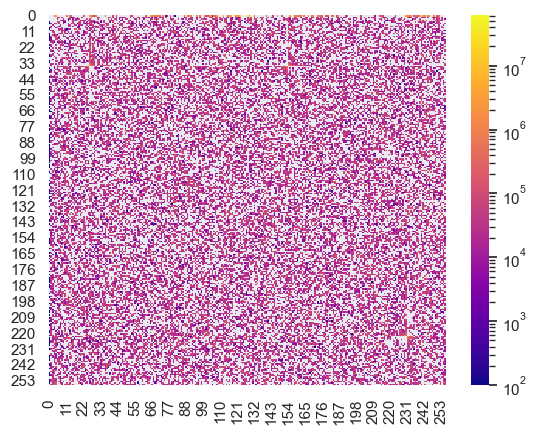

In [355]:
ax = sns.heatmap(data_real,norm =LogNorm(vmin=100),cmap='plasma')

## Calculate 2d-fft

# Mean range doppler

# Theory


## Spatial Doppler signal

$$
\begin{align}
y[l,m] = Aexp(-j\frac{4\pi}{\lambda}R_l)exp(-j2\pi\frac{2v}{\lambda}mT)
\end{align}
$$

Sampling rate fast time or range dim: bandwidth of the radar. this will in most cases corespond the the chirp width.

B = 191.0153846 MHz (from the datasheet) 



$$f_{max}-f_{min} = KT_r$$

The frequency is swept linearly with a positive slope of K and a duration of 𝑇𝑟

L = range bins (number of samples in the range dimension)
L = 256

M= doppler bins (number of samples in the doppler dimension)

PRI = Pulse Repetition Interval = T = 12 core clocks

PRF = Pulse Repetition Frequency = 1/T = 83.3333333 MHz

CPI = Coherent Processing Interval
The total amount of time MT represented by the data matrix is called the coherent processing interval

## The slow-time
The sampling rate ofslow time is PFR

Each row of the matrix represents a series of measurements from the same range bin over M successive pulses

M = number of successive pulses

$$f_d = 2v/\lambda$$

The slow-time or pulse number dimension (horizontal in the figure) is sampled at the pulse repetition interval (PRI) T of the radar. Thus, the sampling rate in this dimension is the pulse repetition frequency (PRF).

The total amount of time MT represented by the data matrix is called the coherent processing interval (CPI)